# Data Pre-Processing: `/r/PC` & `/r/PCM`

- To replicate: **Figure 2**, **Figure A.1**, **Figure B.3**

## 0. Load data

In [1]:
import datetime
import joblib
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns
import sys

sys.path += ['../']

from config import processed_data_path, raw_data_path, figure_path

# Parameters
DATA_PATH = raw_data_path
FIGURES_PATH = figure_path
OUTPUT_PATH = processed_data_path

SUBREDDITS = {
    'PoliticalCompass': 'PC',
    'PoliticalCompassMemes': 'PCM'}

# Flairs order for plots:
FLAIRS_ORDER = ['LibLeft', 'Left', 'AuthLeft',
                'LibCenter', 'Centrist', 'AuthCenter',
                'LibRight', 'Right', 'AuthRight']

FLAIR_ORDER_SOCIAL = ['Lib', 'Center', 'Auth']
FLAIR_ORDER_ECONOMIC = ['Left', 'Center', 'Right']

SOCIAL_AXIS = {'AuthLeft': 'Auth',
               'AuthCenter': 'Auth',
               'AuthRight': 'Auth',
               'Left': 'Center',
               'Centrist': 'Center',
               'Right': 'Center',
               'LibLeft': 'Lib',
               'LibCenter': 'Lib',
               'LibRight': 'Lib'}

ECONOMIC_AXIS = {'AuthLeft': 'Left',
                 'Left': 'Left',
                 'LibLeft': 'Left',
                 'AuthCenter': 'Center',
                 'Centrist': 'Center',
                 'LibCenter': 'Center',
                 'LibRight': 'Right',
                 'Right': 'Right',
                 'AuthRight': 'Right'}

# Plots style
#plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk', rc={'font.size': 14.0,
                            'axes.labelsize': 14.0,
                            'axes.titlesize': 14.0,
                            'xtick.labelsize': 12.0,
                            'ytick.labelsize': 12.0,
                            'legend.fontsize': 12.0,
                            'legend.title_fontsize': 16.0,
                            'patch.linewidth': 1.5,
                            'font.family': 'serif',
                            'font.serif': 'Linux Libertine O',
                           }
               )

PALETTE = {
    'social': {
        'Lib': 'tab:blue',
        'Center': 'tab:orange',
        'Auth': 'tab:green'
    },
    'economic': {
        'Left': 'tab:red',
        'Center': 'tab:purple',
        'Right': 'tab:brown'
    }
}

axes_order = {
    'social': FLAIR_ORDER_SOCIAL,
    'economic': FLAIR_ORDER_ECONOMIC,
    'flair': FLAIRS_ORDER
}

# Functions
def flair_set_clean(x: str) -> str:
    """
    Removes all curly braces, single quotes, and commas from a string.
    Args:
        x: The string to be cleaned.
    Returns:
        The cleaned string.
    """
    d = {'{': '',
         '}': '',
         '\'': '',
         ',': '/'}

    for c in list(d.keys()):
        x = x.replace(c, d[c])
    return x

In [2]:
# Load data
submissions_df = {}
comments_df = {}

for S in SUBREDDITS.keys():
    submissions_df[S] = pd.read_csv(DATA_PATH + f"submissions_anonymized_{SUBREDDITS[S]}" + ".csv")
    print(f"{S}:")
    print(f"\tSubmissions loaded ✓")
    
    comments_df[S] = pd.read_csv(DATA_PATH + f"comments_anonymized_{SUBREDDITS[S]}" + ".csv")
    print(f"\tComments loaded ✓")

deleted_user = 478679
blacklist = joblib.load(DATA_PATH + f"blacklist_anonymized.joblib")

PoliticalCompass:
	Submissions loaded ✓
	Comments loaded ✓
PoliticalCompassMemes:
	Submissions loaded ✓
	Comments loaded ✓


## 1. Clean data

In [3]:
# Flairs for PC & PCM
flairs_list = {}
for S in SUBREDDITS.keys():
    flairs_list[S] = list(pd.concat([submissions_df[S], comments_df[S]])['author_flair_text'].unique())
    # To remove nan/"None" values
        # isinstance(x, float) and x != x: return True only if x == nan (nan: float)
    flairs_list[S] = [x for x in flairs_list[S] if (~isinstance(x, float) and x == x and x != 'None')]
    print(f"{S}:")
    print(f"\t nan/None removed for 'author_flair_text' (submissions/comments) ✓")

PoliticalCompass:
	 nan/None removed for 'author_flair_text' (submissions/comments) ✓
PoliticalCompassMemes:
	 nan/None removed for 'author_flair_text' (submissions/comments) ✓


In [4]:
flairs_list

{'PoliticalCompass': [':libleft: - LibLeft',
  ':lib: - LibCenter',
  ':authleft: - AuthLeft',
  ':auth: - AuthCenter',
  ':libright: - LibRight',
  ':left: - Left',
  ':authright: - AuthRight',
  ':right: - Right',
  ':centrist: - Centrist',
  ':user_flair_PolComp: - /r/PoliticalCompass',
  '\u200e',
  'Undecided/Exploring'],
 'PoliticalCompassMemes': [':libleft: - LibLeft',
  ':libright: - LibRight',
  ':centrist: - Centrist',
  ':left: - Left',
  ':authright: - AuthRight',
  ':libright2: - LibRight',
  ':lib: - LibCenter',
  ':authleft: - AuthLeft',
  ':right: - Right',
  ':auth: - AuthCenter',
  ':CENTG: - Centrist',
  ':centrist:BALKAN UNITED:centrist:',
  ':contestauthleft: - Chad AuthLeft',
  ':authcenterboot: - Chad AuthCenter',
  ':crownauthright: - Chad AuthRight',
  ':spongebob_flair_3: -  Chad LibLeft',
  ':odd_possesion_crown_4: - Chad Centrist',
  ':ChadAuthCenterEagleV4: - Chad AuthCenter',
  ':PoliticalCompass:',
  ':centrist: - Transhumanist',
  ':centrist: - Grand Inq

In [5]:
# Clean data
for S in SUBREDDITS.keys():
    # 1. Clean flairs (political opinions)
    submissions_df[S]['flair'] = submissions_df[S]['author_flair_text'].str.split('- ').str[1]
    comments_df[S]['flair'] = comments_df[S]['author_flair_text'].str.split('- ').str[1]
    print(f"{S}:")
    print(f"\t flairs cleaned (submissions/comments) ✓")
    
    # 2. Date-time
    # Submissions
    date_time = submissions_df[S]['created_utc'].apply(datetime.datetime.fromtimestamp)
    submissions_df[S]['date_time'] = date_time
    submissions_df[S]['date_time'] = pd.to_datetime(submissions_df[S]['date_time']).dt.date
    # For the plots
    submissions_df[S]['date_time'] = pd.to_datetime(submissions_df[S]['date_time'], errors='coerce')
    submissions_df[S]['year'] = submissions_df[S]['date_time'].dt.year.rename('year')
    
    # Comments
    date_time = comments_df[S]['created_utc'].apply(datetime.datetime.fromtimestamp)
    comments_df[S]['date_time'] = date_time
    comments_df[S]['date_time'] = pd.to_datetime(comments_df[S]['date_time']).dt.date
    # For the plots
    comments_df[S]['date_time'] = pd.to_datetime(comments_df[S]['date_time'], errors='coerce')
    comments_df[S]['year'] = comments_df[S]['date_time'].dt.year.rename('year')
    print(f"\t time data cleaned (submissions/comments) ✓")

PoliticalCompass:
	 flairs cleaned (submissions/comments) ✓
	 time data cleaned (submissions/comments) ✓
PoliticalCompassMemes:
	 flairs cleaned (submissions/comments) ✓
	 time data cleaned (submissions/comments) ✓


## 2. Select time period for analysis: 2020-2022

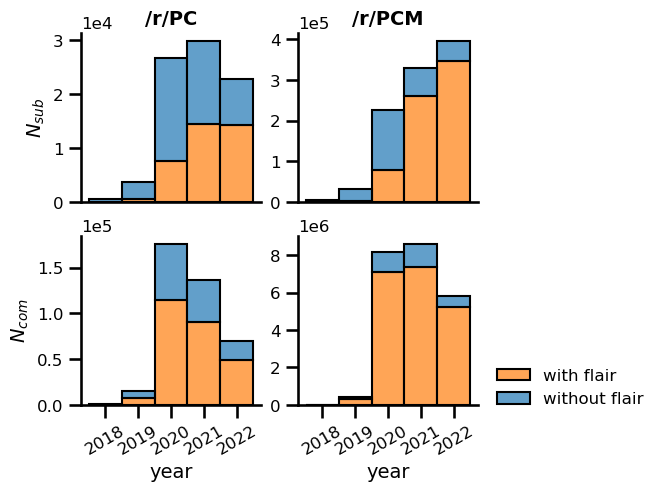

In [6]:
# Posts number by:
    # 1. Total users
    # 2. Users with flair
    
fig = plt.figure(layout='constrained')
ax = fig.subplot_mosaic('''
AB
CD
''', sharex=True)

plot_order = {
    'PoliticalCompass': ('A', 'B'),
    'PoliticalCompassMemes': ('C', 'D')
}

for S in SUBREDDITS.keys():
    submissions_df[S]['with_flair'] = ~(submissions_df[S].flair.isna().values)
    comments_df[S]['with_flair'] = ~(comments_df[S].flair.isna().values)
    
    # Submissions
    sns.histplot(data=submissions_df[S][submissions_df[S].year >= 2018],
                 x='year',
                 hue='with_flair',
                 multiple='stack',
                 ax=ax[plot_order[S][0]],
                 zorder=3,
                 alpha=.7,
                 discrete=True)
    # Comments
    sns.histplot(data=comments_df[S][comments_df[S].year >= 2018],
                 x='year',
                 hue='with_flair',
                 multiple='stack',
                 ax=ax[plot_order[S][1]],
                 zorder=3,
                 alpha=.7,
                 discrete=True)
    
    sns.despine(right=True)
    
    for idx in [0, 1]:
        ax[plot_order[S][idx]].set_xlabel('')
        ax[plot_order[S][idx]].set_ylabel('')

        ax[plot_order[S][idx]].get_legend().remove()
        ax[plot_order[S][idx]].tick_params(axis='x', labelrotation=30)
        ax[plot_order[S][idx]].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax[plot_order[S][idx]].ticklabel_format(axis='y', scilimits=(0,0))

ax['A'].set_title('/r/PC',weight='bold')
ax['A'].set_ylabel(r'$N_{sub}$')
ax['A'].tick_params(bottom=False)
ax['B'].set_title('/r/PCM',weight='bold')
ax['B'].tick_params(bottom=False)
ax['C'].set_ylabel(r'$N_{com}$')
ax['C'].set_xlabel(r'year')
ax['D'].set_xlabel(r'year')
ax['D'].legend(['with flair', 'without flair'], framealpha=0,
               bbox_to_anchor =(2.0,-0.10),
               loc='lower right')

fig.savefig(FIGURES_PATH + "0_1_submissions_comments_in_time.pdf", bbox_inches='tight')
plt.show()

In [7]:
# Select years 2020-2022 for submissions/comments
selected_submissions_df = {}
selected_comments_df = {}

for S in SUBREDDITS.keys():
    selected_submissions_df[S] = submissions_df[S][submissions_df[S]['year'].isin({2020, 2021, 2022})]
    selected_comments_df[S] = comments_df[S][comments_df[S]['year'].isin({2020, 2021, 2022})]

In [8]:
for S in SUBREDDITS.keys():
    print(S + ":\n",
          "Sub number for time period 2020-2022: "
          f"{len(selected_submissions_df[S])}",
          f"({round(100 * len(selected_submissions_df[S]) / len(submissions_df[S]), 2)}%)\n",
          
          "Com number for time period 2020-2022: ", 
          f"{len(selected_comments_df[S])}",
          f"({round(100 * len(selected_comments_df[S]) / len(comments_df[S]), 2)}%)\n")

PoliticalCompass:
 Sub number for time period 2020-2022: 79368 (94.77%)
 Com number for time period 2020-2022:  952550 (96.32%)

PoliticalCompassMemes:
 Sub number for time period 2020-2022: 383169 (96.14%)
 Com number for time period 2020-2022:  22653346 (98.12%)



## 3. Users with single & multiple flair: some numbers

In [9]:
# Select submissions/comments by users with political opinion flairs
flaired_submissions_df = {}
flaired_comments_df = {}

for S in SUBREDDITS.keys():
    flaired_submissions_df[S] = selected_submissions_df[S][(selected_submissions_df[S]['flair']
                                                            .isin(FLAIRS_ORDER)) & \
                                                           (~selected_submissions_df[S]['author']
                                                            .isin(blacklist))]
    flaired_comments_df[S] = selected_comments_df[S][(selected_comments_df[S]['flair']
                                                      .isin(FLAIRS_ORDER)) & \
                                                     (~selected_comments_df[S]['author']
                                                      .isin(blacklist))]

In [10]:
# Users with single and multiple flairs
users_df = {}
single_flair_users_df = {}
multiple_flair_users_df = {}

for S in SUBREDDITS.keys():
    users_df[S] = (pd.DataFrame(pd.concat([flaired_submissions_df[S], flaired_comments_df[S]])
                                .groupby('author')
                                .apply(lambda x: set(x['flair'].tolist()))
                                .reset_index()
                                .rename(columns={0: 'flair_set'})))
    users_df[S]['flair_count'] = users_df[S]['flair_set'].apply(lambda x: len(x))
    
    single_flair_users_df[S] = users_df[S][users_df[S]['flair_count'] == 1].reset_index(drop=True)
    single_flair_users_df[S]['flair'] = single_flair_users_df[S]['flair_set'].apply(lambda x: x.pop())
    single_flair_users_df[S] = single_flair_users_df[S].drop(columns=['flair_set', 'flair_count'])
    
    multiple_flair_users_df[S] = users_df[S][users_df[S]['flair_count'] > 1].reset_index(drop=True)
    multiple_flair_users_df[S] = multiple_flair_users_df[S].drop(columns=['flair_count'])

/tmp/ipykernel_1230244/1386599923.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: set(x['flair'].tolist()))
/tmp/ipykernel_1230244/1386599923.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: set(x['flair'].tolist()))


In [11]:
for S in SUBREDDITS.keys():
    print(f"{S} (users with political flair):\n",
          "Users with single flair: ",
          len(single_flair_users_df[S]), f"({round(100 * len(single_flair_users_df[S]) / len(users_df[S]), 2)}%)\n",
          "Users with multiple flairs: ",
          len(multiple_flair_users_df[S]), f"({round(100 * len(multiple_flair_users_df[S]) / len(users_df[S]), 2)}%)\n",
         )

PoliticalCompass (users with political flair):
 Users with single flair:  22503 (89.84%)
 Users with multiple flairs:  2544 (10.16%)

PoliticalCompassMemes (users with political flair):
 Users with single flair:  258428 (89.39%)
 Users with multiple flairs:  30658 (10.61%)



### Type of users: some numbers for submissions/comments (Table A.1)

In [12]:
for S in SUBREDDITS.keys():
    print(S + ":\n",
          "Sub by deleted-accounts:",
          f"{sum((~selected_submissions_df[S].author.isin(set(single_flair_users_df[S].author))) & (selected_submissions_df[S].author == deleted_user))}",
          f"({round(100 * sum((~selected_submissions_df[S].author.isin(set(single_flair_users_df[S].author))) & (selected_submissions_df[S].author == deleted_user)) / len(selected_submissions_df[S]), 2)}%)",
          "\n",
          "Sub by bots:",
          f"{sum((~selected_submissions_df[S].author.isin(set(single_flair_users_df[S].author))) & (selected_submissions_df[S].author.isin(blacklist)) & (selected_submissions_df[S].author != deleted_user))}",
          f"({round(100 * sum((~selected_submissions_df[S].author.isin(set(single_flair_users_df[S].author))) & (selected_submissions_df[S].author.isin(blacklist)) & (selected_submissions_df[S].author != deleted_user)) / len(selected_submissions_df[S]), 2)}%)",
          "\n",
          "Sub by accounts with non-unique political flairs:",
          f"{sum((~selected_submissions_df[S].author.isin(set(single_flair_users_df[S].author))) & (~selected_submissions_df[S].author.isin(blacklist)) & ((selected_submissions_df[S].author.isin(set(multiple_flair_users_df[S].author))) | (~selected_submissions_df[S].flair.isin(FLAIRS_ORDER))))}",
          f"({round(100 * sum((~selected_submissions_df[S].author.isin(set(single_flair_users_df[S].author))) & (~selected_submissions_df[S].author.isin(blacklist)) & ((selected_submissions_df[S].author.isin(set(multiple_flair_users_df[S].author))) | (~selected_submissions_df[S].flair.isin(FLAIRS_ORDER)))) / len(selected_submissions_df[S]), 2)}%)",
          "\n",
          "Sub by accounts with unique political flairs:",
          f"{sum(selected_submissions_df[S].author.isin(set(single_flair_users_df[S].author)))}",
          f"({round(100 * sum(selected_submissions_df[S].author.isin(set(single_flair_users_df[S].author))) / len(selected_submissions_df[S]), 2)}%)",
          "\n\n",
          
          "Com by deleted-accounts:",
          f"{sum((~selected_comments_df[S].author.isin(set(single_flair_users_df[S].author))) & (selected_comments_df[S].author == deleted_user))}",
          f"({round(100 * sum((~selected_comments_df[S].author.isin(set(single_flair_users_df[S].author))) & (selected_comments_df[S].author == deleted_user)) / len(selected_comments_df[S]), 2)}%)",
          "\n",
          "Com by bots:",
          f"{sum((~selected_comments_df[S].author.isin(set(single_flair_users_df[S].author))) & (selected_comments_df[S].author.isin(blacklist)) & (selected_comments_df[S].author != deleted_user))}",
          f"({round(100 * sum((~selected_comments_df[S].author.isin(set(single_flair_users_df[S].author))) & (selected_comments_df[S].author.isin(blacklist)) & (selected_comments_df[S].author != deleted_user)) / len(selected_comments_df[S]), 2)}%)",
          "\n",
          "Com by accounts with non-unique political flairs:",
          f"{sum((~selected_comments_df[S].author.isin(set(single_flair_users_df[S].author))) & (~selected_comments_df[S].author.isin(blacklist)) & ((selected_comments_df[S].author.isin(set(multiple_flair_users_df[S].author))) | (~selected_comments_df[S].flair.isin(FLAIRS_ORDER))))}",
          f"({round(100 * sum((~selected_comments_df[S].author.isin(set(single_flair_users_df[S].author))) & (~selected_comments_df[S].author.isin(blacklist)) & ((selected_comments_df[S].author.isin(set(multiple_flair_users_df[S].author))) | (~selected_comments_df[S].flair.isin(FLAIRS_ORDER)))) / len(selected_comments_df[S]), 2)}%)",
          "\n",
          "Com by accounts with unique political flairs:",
          f"{sum(selected_comments_df[S].author.isin(set(single_flair_users_df[S].author)))}",
          f"({round(100 * sum(selected_comments_df[S].author.isin(set(single_flair_users_df[S].author))) / len(selected_comments_df[S]), 2)}%)",
          "\n\n"
         )

PoliticalCompass:
 Sub by deleted-accounts: 27556 (34.72%) 
 Sub by bots: 198 (0.25%) 
 Sub by accounts with non-unique political flairs: 22552 (28.41%) 
 Sub by accounts with unique political flairs: 29062 (36.62%) 

 Com by deleted-accounts: 90363 (9.49%) 
 Com by bots: 5750 (0.6%) 
 Com by accounts with non-unique political flairs: 293672 (30.83%) 
 Com by accounts with unique political flairs: 562765 (59.08%) 


PoliticalCompassMemes:
 Sub by deleted-accounts: 115906 (30.25%) 
 Sub by bots: 2781 (0.73%) 
 Sub by accounts with non-unique political flairs: 84234 (21.98%) 
 Sub by accounts with unique political flairs: 180248 (47.04%) 

 Com by deleted-accounts: 2450160 (10.82%) 
 Com by bots: 582101 (2.57%) 
 Com by accounts with non-unique political flairs: 5048273 (22.28%) 
 Com by accounts with unique political flairs: 14572812 (64.33%) 




In [13]:
for S in SUBREDDITS.keys():
    print(S + ":\n",
          "Sub by users with single flair: ",
          f"{sum(flaired_submissions_df[S]['author'].isin(set(single_flair_users_df[S]['author'])))}",
          f"({round(100 * sum(flaired_submissions_df[S]['author'].isin(set(single_flair_users_df[S]['author']))) / len(flaired_submissions_df[S]), 2)}%)\n",
          "Sub by users with multiple flairs: ",
          f"{sum(flaired_submissions_df[S]['author'].isin(set(multiple_flair_users_df[S]['author'])))}",
          f"({round(100 * sum(flaired_submissions_df[S]['author'].isin(set(multiple_flair_users_df[S]['author']))) / len(flaired_submissions_df[S]), 2)}%)\n\n",
          "Com by users with single flair: ",
          f"{sum(flaired_comments_df[S]['author'].isin(set(single_flair_users_df[S]['author'])))}",
          f"({round(100 * sum(flaired_comments_df[S]['author'].isin(set(single_flair_users_df[S]['author']))) / len(flaired_comments_df[S]), 2)}%)\n",
          "Com by users with multiple flairs: ",
          f"{sum(flaired_comments_df[S]['author'].isin(set(multiple_flair_users_df[S]['author'])))}",
          f"({round(100 * sum(flaired_comments_df[S]['author'].isin(set(multiple_flair_users_df[S]['author']))) / len(flaired_comments_df[S]), 2)}%)\n\n",
         )

PoliticalCompass:
 Sub by users with single flair:  26119 (72.23%)
 Sub by users with multiple flairs:  10040 (27.77%)

 Com by users with single flair:  498139 (73.0%)
 Com by users with multiple flairs:  184206 (27.0%)


PoliticalCompassMemes:
 Sub by users with single flair:  179119 (71.25%)
 Sub by users with multiple flairs:  72280 (28.75%)

 Com by users with single flair:  14509574 (75.7%)
 Com by users with multiple flairs:  4657814 (24.3%)




## 5. Community analysis
### Users & post/comments by flairs

In [14]:
single_flair_submissions_df = {}
single_flair_comments_df = {}

for S in SUBREDDITS.keys():
    print(f"{S}:")
    print(f"\t total submissions, submissions by single flair users: ",
          flaired_submissions_df[S].author.count(), ",",
          (flaired_submissions_df[S][flaired_submissions_df[S]
                                      .author.isin(single_flair_users_df[S]
                                                   .author.values)].author.count())
         )
    print(f"\t total comments, comments by single flair users: ",
          flaired_comments_df[S].author.count(), ",",
          (flaired_comments_df[S][flaired_comments_df[S]
                                   .author.isin(single_flair_users_df[S]
                                                .author.values)].author.count())
         )
    
    single_flair_submissions_df[S] = (flaired_submissions_df[S][flaired_submissions_df[S]
                                                             .author.isin(single_flair_users_df[S]
                                                                          .author.values)])
    print(f"\t\t get submissions by users with single flair ✓")
    single_flair_comments_df[S] = (flaired_comments_df[S][flaired_comments_df[S]
                                                       .author.isin(single_flair_users_df[S]
                                                                    .author.values)])
    print(f"\t\t get comments by users with single flair ✓")

PoliticalCompass:
	 total submissions, submissions by single flair users:  36159 , 26119
	 total comments, comments by single flair users:  682345 , 498139
		 get submissions by users with single flair ✓
		 get comments by users with single flair ✓
PoliticalCompassMemes:
	 total submissions, submissions by single flair users:  251399 , 179119
	 total comments, comments by single flair users:  19167388 , 14509574
		 get submissions by users with single flair ✓
		 get comments by users with single flair ✓


In [15]:
for S in SUBREDDITS.keys():
    single_flair_users_df[S]['social'] = single_flair_users_df[S].flair.map(SOCIAL_AXIS.get).values
    single_flair_users_df[S]['economic'] = single_flair_users_df[S].flair.map(ECONOMIC_AXIS.get).values

In [16]:
for S in SUBREDDITS.keys():
    single_flair_submissions_df[S]['social'] = single_flair_submissions_df[S].flair.map(SOCIAL_AXIS.get).values
    single_flair_submissions_df[S]['economic'] = single_flair_submissions_df[S].flair.map(ECONOMIC_AXIS.get).values
    print(f"{S}:")
    print(f"\t get social/economic for submissions ✓")
    
    single_flair_comments_df[S]['social'] = single_flair_comments_df[S].flair.map(SOCIAL_AXIS.get).values
    single_flair_comments_df[S]['economic'] = single_flair_comments_df[S].flair.map(ECONOMIC_AXIS.get).values
    print(f"\t get social/economic for comments ✓")

PoliticalCompass:
	 get social/economic for submissions ✓


/tmp/ipykernel_1230244/2893948102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_flair_submissions_df[S]['social'] = single_flair_submissions_df[S].flair.map(SOCIAL_AXIS.get).values
/tmp/ipykernel_1230244/2893948102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_flair_submissions_df[S]['economic'] = single_flair_submissions_df[S].flair.map(ECONOMIC_AXIS.get).values
/tmp/ipykernel_1230244/2893948102.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

	 get social/economic for comments ✓
PoliticalCompassMemes:
	 get social/economic for submissions ✓


/tmp/ipykernel_1230244/2893948102.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_flair_comments_df[S]['social'] = single_flair_comments_df[S].flair.map(SOCIAL_AXIS.get).values


	 get social/economic for comments ✓


/tmp/ipykernel_1230244/2893948102.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_flair_comments_df[S]['economic'] = single_flair_comments_df[S].flair.map(ECONOMIC_AXIS.get).values


#### Summary numbers by flair

/tmp/ipykernel_1230244/966324204.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=(summary_numbers_df[p]
/tmp/ipykernel_1230244/966324204.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=(summary_numbers_df[p]
/tmp/ipykernel_1230244/966324204.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=(summary_numbers_df[p]
/tmp/ipykernel_1230244/966324204.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for 

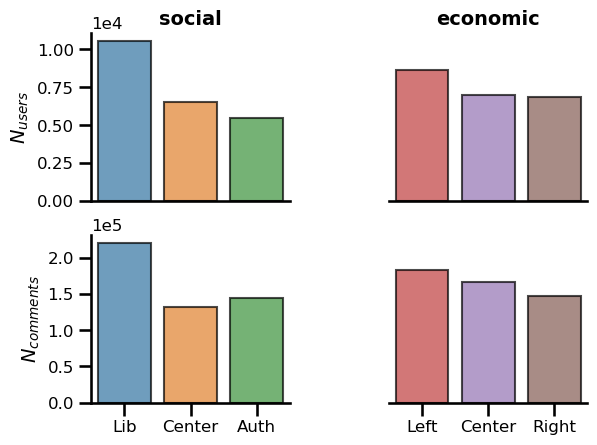

/tmp/ipykernel_1230244/966324204.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=(summary_numbers_df[p]
/tmp/ipykernel_1230244/966324204.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=(summary_numbers_df[p]
/tmp/ipykernel_1230244/966324204.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=(summary_numbers_df[p]
/tmp/ipykernel_1230244/966324204.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for 

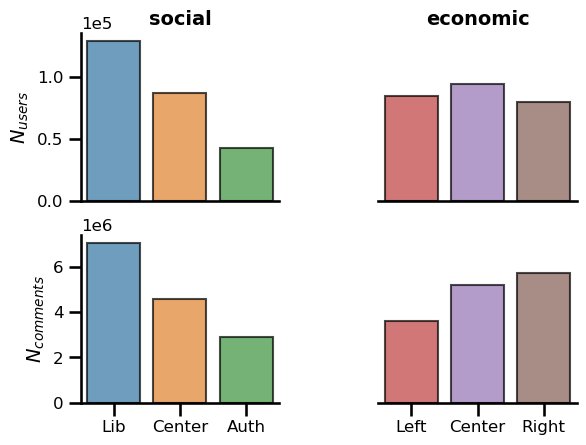

In [17]:
summary_params = {
    'users': ('author', r'$N_{users}$'),
    'comments': ('author', r'$N_{comments}$')
}

for S in SUBREDDITS.keys():
    fig = plt.figure()#layout='tight')#, figsize=(5,5))
    ax = fig.subplot_mosaic('''
    AB
    EF
    ''')

    plot_order = {
        ('social', 'users'): 'A',
        ('economic', 'users'): 'B',
        ('social', 'comments'): 'E',
        ('economic', 'comments'): 'F',
    }

    summary_numbers_df = {
        'users': single_flair_users_df[S],
        'posts': single_flair_submissions_df[S],
        'comments': single_flair_comments_df[S],
    }

    for axis in ['social', 'economic']:
        for p in ['users', 'comments']:#'posts', 'comments']:
            sns.barplot(data=(summary_numbers_df[p]
                              .groupby(axis)
                              [summary_params[p][0]].count().reset_index()),
                        y=summary_params[p][0], x=axis,
                        ax=ax[plot_order[(axis,p)]],
                        alpha=0.7,
                        order=axes_order[axis],
                        palette=PALETTE[axis],
                        edgecolor='k'
                       )
            ax[plot_order[(axis,p)]].set_xlabel('')
            ax[plot_order[(axis,p)]].set_ylabel('')
            ax[plot_order[(axis,p)]].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
            sns.despine(right=True)

            if p == 'users':
                ax[plot_order[(axis,p)]].set_title(axis, weight='bold')
            if p == 'comments':
                ax[plot_order[(axis,p)]].tick_params(bottom=True, labelbottom=True)
            
            if axis == 'social':
                ax[plot_order[(axis,p)]].tick_params(left=True, labelleft=True)
                ax[plot_order[(axis,p)]].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
                ax[plot_order[(axis,p)]].set_ylabel(summary_params[p][1])                

    ax['B'].sharey(ax['A'])
    ax['F'].sharey(ax['E'])
    sns.despine(ax=ax['B'], left=True)
    sns.despine(ax=ax['F'], left=True)
    
    plt.subplots_adjust(wspace=0.5)
    
    plt.savefig(FIGURES_PATH + f"0_1_users_comments_by_ideologies_{SUBREDDITS[S]}.pdf", bbox_inches='tight')
    plt.show()

## 6. Save data

In [18]:
for S in SUBREDDITS.keys():
    # Save users with single flair
   single_flair_users_df[S].to_csv(OUTPUT_PATH + f"single_flair_anonymized_users_{SUBREDDITS[S]}.csv",
                                   index=False, header=True)